In [1]:
import numpy as np
import pandas as pd

### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 7000
days = 15

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,i+10,i+11,i+12,i+13,i+14,Close
0,249.86,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759
1,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267
2,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021
3,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,236.775
4,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,236.775,241.759


### Calculate squared daily deviation 

In [5]:
#Calculate squared daily deviation
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
dv = np.sqrt((dv ** 2).mean())
dv

dv    7.558524
dtype: float64

### Split train/test set

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Create cross validation folds

In [7]:
def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 

### Define metrics and print metrics

In [8]:
# Import metrics, Crete custom metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    print('RMSE %f'%  rmse(test, pred))
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')

In [9]:
n_splits = 7
size =1000

cv_sets = create_cv_sets(n_splits, size)

### Benchmark model 

In [10]:
def model_persistence(x):
    return x

def set_prediction(test_X):
    predictions = list()
    for x in test_X['i+%s' % str(days-1)]:
        yhat = model_persistence(x)
        predictions.append(yhat)
    return predictions

#Iterate through cv_sets, calc errors, print metrics
benchmark_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    pred = set_prediction(X_test)
    benchmark_errs.append(rmse(y_test['Close'], pred))
    print_metrics(y_test['Close'], pred)

RMSE 4.730149
Root Mean Squared Percentage Error 1.053588
Mean Absolute Error: 3.589005
Explained Variance Score: 0.977357
Mean Squared Error: 22.374307
R2 score: 0.977121

RMSE 4.730145
Root Mean Squared Percentage Error 1.052969
Mean Absolute Error: 3.589000
Explained Variance Score: 0.977528
Mean Squared Error: 22.374269
R2 score: 0.977330

RMSE 4.769385
Root Mean Squared Percentage Error 1.059620
Mean Absolute Error: 3.626385
Explained Variance Score: 0.977500
Mean Squared Error: 22.747034
R2 score: 0.977257

RMSE 4.818575
Root Mean Squared Percentage Error 1.066213
Mean Absolute Error: 3.654420
Explained Variance Score: 0.977555
Mean Squared Error: 23.218663
R2 score: 0.977290

RMSE 4.914917
Root Mean Squared Percentage Error 1.081329
Mean Absolute Error: 3.719850
Explained Variance Score: 0.977430
Mean Squared Error: 24.156412
R2 score: 0.977098

RMSE 5.088772
Root Mean Squared Percentage Error 1.106970
Mean Absolute Error: 3.807080
Explained Variance Score: 0.976974
Mean Squared

### Train and Tune Linear Regressor

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

def get_lr_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Iterate through cross validation sets, calc errors, print metrics

In [12]:
#Iterate through cv_sets, calc errors, print metrics
lr_regs = []
lr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    lr_reg = get_lr_model(X_train, y_train)
    lr_regs.append(lr_reg)
    pred = lr_reg.predict(X_test)
    lr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)

RMSE 4.734350
Root Mean Squared Percentage Error 1.054045
Mean Absolute Error: 3.641621
Explained Variance Score: 0.977190
Mean Squared Error: 22.414070
R2 score: 0.977081

RMSE 4.736891
Root Mean Squared Percentage Error 1.054041
Mean Absolute Error: 3.645021
Explained Variance Score: 0.977343
Mean Squared Error: 22.438138
R2 score: 0.977265

RMSE 4.783293
Root Mean Squared Percentage Error 1.061934
Mean Absolute Error: 3.684445
Explained Variance Score: 0.977234
Mean Squared Error: 22.879891
R2 score: 0.977125

RMSE 4.819607
Root Mean Squared Percentage Error 1.065845
Mean Absolute Error: 3.705027
Explained Variance Score: 0.977393
Mean Squared Error: 23.228608
R2 score: 0.977281

RMSE 4.896625
Root Mean Squared Percentage Error 1.077672
Mean Absolute Error: 3.755883
Explained Variance Score: 0.977431
Mean Squared Error: 23.976936
R2 score: 0.977268

RMSE 5.079582
Root Mean Squared Percentage Error 1.104621
Mean Absolute Error: 3.845646
Explained Variance Score: 0.976873
Mean Squared

In [13]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

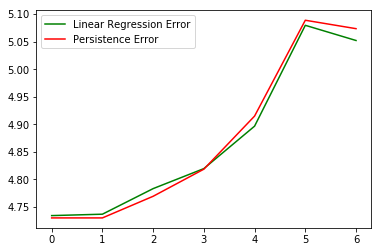

In [14]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')

plt.legend()
plt.show()

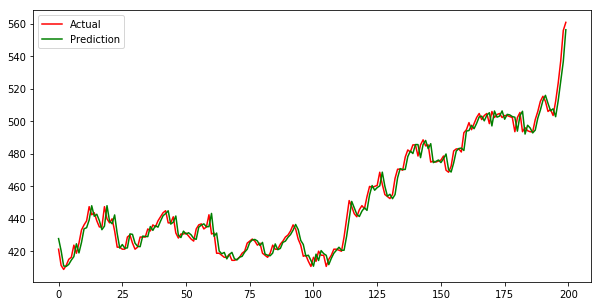

In [15]:
rcParams['figure.figsize'] = 10,5
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, lr_regs[n_splits - 1].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [16]:
lr_regs[6].coef_

array([[ 0.03034498, -0.04234196,  0.05838648, -0.00502661, -0.04672658,
         0.01368233,  0.0196181 ,  0.03103964, -0.01350129,  0.01751701,
        -0.13514673,  0.17229513, -0.05984908, -0.09244253,  1.05290303]])

In [17]:
from sklearn.linear_model import Ridge 

def get_ridge_model(X_train, X_test, y_train, y_test):
    r_reg = Ridge()
    r_reg.fit(X_train, y_train)
    return r_reg

In [18]:
#Iterate through cv_sets, calc errors, print metrics
rr_regs=[]
rr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    rr_reg = get_ridge_model(X_train,X_test,y_train,y_test)
    pred = rr_reg.predict(X_test)
    rr_regs.append(rr_reg)
    rr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)    

RMSE 4.793773
Root Mean Squared Percentage Error 1.064788
Mean Absolute Error: 3.702716
Explained Variance Score: 0.977190
Mean Squared Error: 22.980258
R2 score: 0.976502

RMSE 4.792257
Root Mean Squared Percentage Error 1.063939
Mean Absolute Error: 3.700587
Explained Variance Score: 0.977349
Mean Squared Error: 22.965727
R2 score: 0.976731

RMSE 4.850355
Root Mean Squared Percentage Error 1.073975
Mean Absolute Error: 3.750095
Explained Variance Score: 0.977215
Mean Squared Error: 23.525940
R2 score: 0.976479

RMSE 4.889292
Root Mean Squared Percentage Error 1.078004
Mean Absolute Error: 3.769314
Explained Variance Score: 0.977334
Mean Squared Error: 23.905173
R2 score: 0.976619

RMSE 4.979985
Root Mean Squared Percentage Error 1.092184
Mean Absolute Error: 3.829371
Explained Variance Score: 0.977338
Mean Squared Error: 24.800246
R2 score: 0.976488

RMSE 5.171586
Root Mean Squared Percentage Error 1.120326
Mean Absolute Error: 3.917359
Explained Variance Score: 0.976727
Mean Squared

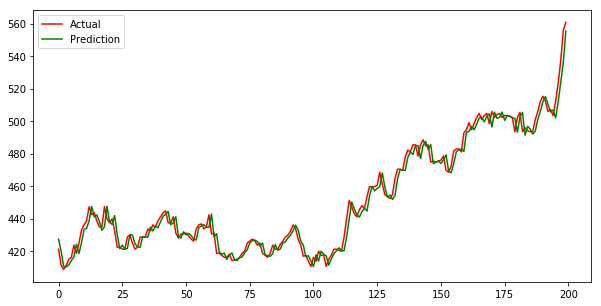

In [19]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, rr_regs[6].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [20]:
rr_regs[1].coef_

array([[ 0.03290649, -0.045081  ,  0.0619717 , -0.00540411, -0.04862029,
         0.00848372,  0.01784502,  0.0312394 , -0.00881302,  0.01823023,
        -0.13758844,  0.1766245 , -0.0639728 , -0.09481773,  1.05281446]])

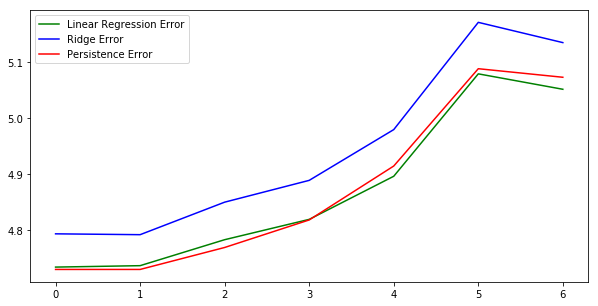

In [21]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [22]:
from sklearn.svm import LinearSVR
def lsvr(X_train, X_test, y_train, y_test):
    svr = LinearSVR()
    svr.fit(X_train, y_train.values.ravel())
    return svr

In [23]:
#Iterate through cv_sets, calc errors, print metrics
svrs=[]
svr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svr = lsvr(X_train, X_test, y_train, y_test)
    svrs.append(svr)
    pred = svr.predict(X_test)
    svr_errs.append(rmse(y_test.values.ravel(), pred)) 
    print_metrics(y_test.values.ravel(), pred)


RMSE 6.294498
Root Mean Squared Percentage Error 1.388855
Mean Absolute Error: 5.228356
Explained Variance Score: 0.977132
Mean Squared Error: 39.620709
R2 score: 0.959486

RMSE 5.073839
Root Mean Squared Percentage Error 1.136377
Mean Absolute Error: 3.911176
Explained Variance Score: 0.977301
Mean Squared Error: 25.743842
R2 score: 0.973916

RMSE 4.957241
Root Mean Squared Percentage Error 1.107247
Mean Absolute Error: 3.792484
Explained Variance Score: 0.977225
Mean Squared Error: 24.574239
R2 score: 0.975431

RMSE 8.380795
Root Mean Squared Percentage Error 1.878300
Mean Absolute Error: 7.207887
Explained Variance Score: 0.977259
Mean Squared Error: 70.237719
R2 score: 0.931302

RMSE 5.127800
Root Mean Squared Percentage Error 1.122273
Mean Absolute Error: 3.994541
Explained Variance Score: 0.977394
Mean Squared Error: 26.294334
R2 score: 0.975071

RMSE 7.208807
Root Mean Squared Percentage Error 1.556936
Mean Absolute Error: 5.980092
Explained Variance Score: 0.976555
Mean Squared

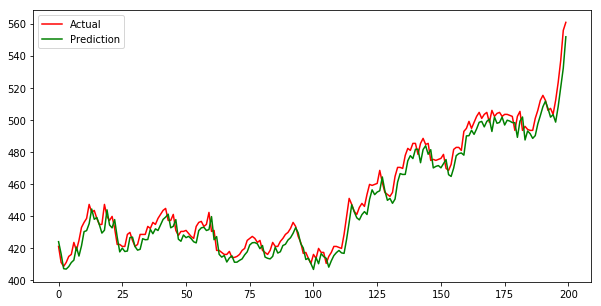

In [24]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

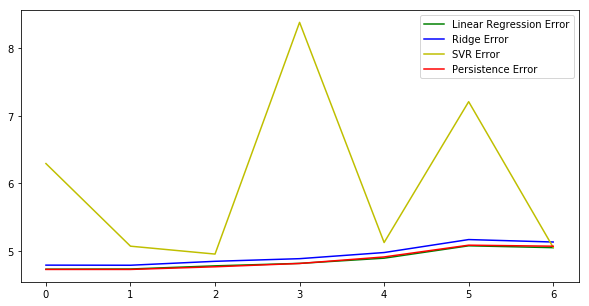

In [25]:
rcParams['figure.figsize'] = 10,5
dvl = [dv]* n_splits
t = range(n_splits)
plt.yticks(np.arange(0, max(svr_errs)))
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, svr_errs, 'y', label='SVR Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [26]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00,301.20, 309.20,307.00,310.20,307.40]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred


array([[308.65636598]])

In [27]:
from sklearn.externals import joblib
joblib.dump(lr_regs[0], 'prediction_model_full.pkl') 

['prediction_model_full.pkl']